
## CPU Instance

Exemplary Calculation:

| Instance      | Pay as you go | 3 year reserved|
| ------------- |:-------------:| --------------:|
| a1.xlarge 8GB RAM| €36.8731/month| ~€15.3996/month|


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import torch
from tqdm import tqdm
import os
import shutil

import os

import PIL
from PIL import Image
from PIL.ImageDraw import Draw

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from scipy.ndimage import affine_transform
from tensorflow.keras import backend as K

import pandas as pd
from tqdm import tqdm

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, RandomGamma, Rotate,IAAAffine
)

from models import *
from dataSet.reader import *
from dataSet.transform import *
from masks.mask import *
from bboxs.bboxs import *

Segmentation Models: using `tf.keras` framework.


https://happywhale.com/browse

![title](sperm_whale_example.jpg)

In [3]:
DATA = 'WC_input/prediction/'
names_test = os.listdir(DATA)
batch_size = len(names_test)

#### Create Mask

In [6]:
WC = []
for img_file in names_test:
    img = cv2.imread(DATA + img_file)
    WC.append(img)
WC = np.array(WC)

In [7]:
from segmentation_models import Unet

mask_model_name = 'seresnet34'
model = Unet(backbone_name=mask_model_name, encoder_weights='imagenet', activation='sigmoid', classes=1)

model.load_weights('masks/fpnseresnet34_384-192_34-0.061-0.976.hdf5')

In [8]:
null_aug = Compose([])
flip_aug = Compose([HorizontalFlip(p=1.0) ])
blur_aug = Compose([Blur(p=1.0)])


test_generator = TestDataGenerator(WC, batch_size=batch_size, aug=null_aug, preprocess_input=preprocess_input, dim=(384, 192), 
                               shuffle=False)
preds = model.predict_generator(test_generator, verbose=1)

test_generator = TestDataGenerator(WC, batch_size=batch_size, aug=flip_aug, preprocess_input=preprocess_input,  dim=(384, 192), shuffle=False)
preds_hflip = model.predict_generator(test_generator, verbose=1)

test_generator = TestDataGenerator(WC, batch_size=batch_size, aug=blur_aug, preprocess_input=preprocess_input,  dim=(384, 192), shuffle=False)
preds_blur = model.predict_generator(test_generator, verbose=1)


Instructions for updating:
Please use Model.predict, which supports generators.
1/1 [==============================] - 0s 380ms/step


In [9]:
TARGET_VAL = []
for i in range(len(preds)):
    pp = (preds[i] + np.fliplr(preds_hflip[i]) + preds_blur[i])/3
    TARGET_VAL.append(pp)

TARGET_VAL = np.array(TARGET_VAL)  

In [10]:
from skimage.morphology import label
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    return rle_encoding(lab_img)


In [11]:
rles = []
for i in tqdm(range(len(TARGET_VAL))):
    rle = list(prob_to_rles(TARGET_VAL[i]))
    rles.append(rle)
    
img_Ids = [Path(fname).stem for fname in names_test]

# Create submission DataFrame
mask_df = pd.DataFrame()
mask_df['id'] = img_Ids
mask_df['rle_mask'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))


import os
if not os.path.exists('WC_input'):
    os.makedirs('WC_input')
mask_df.to_csv("WC_input/model_50A_slim_ensemble.csv", index=False)

100%|██████████| 1/1 [00:00<00:00, 69.34it/s]


In [12]:
mask_df

,id,rle_mask
0,sperm_whale_example,7397 7 7586 11 7775 16 7965 19 8155 23 8346 25...


#### Create Bounding Box

In [13]:
bboxs_model = load_model('bboxs/cropping_2.model')

In [14]:
bbox_df = pd.DataFrame(columns=['Image','x0','y0','x1','y1']).set_index('Image')
for img in tqdm(names_test):
    bbox_df.loc[img] = make_bbox(os.path.join(DATA,img), bboxs_model)

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


In [15]:
import os
if not os.path.exists('WC_input'):
    os.makedirs('WC_input')
bbox_df.to_csv("WC_input/bboxs.csv")

In [16]:
bbox_df

,x0,y0,x1,y1
Image,,,,
sperm_whale_example.jpg,60,56,736,243


## Create embeddings

#### Load Images to model 

In [17]:

def train_collate(batch):

    batch_size = len(batch)
    images = [
    ]
    names = []
    for b in range(batch_size):
        if batch[b][0] is None:
            continue
        else:
            images.extend(batch[b][0])
            names.append(batch[b][1])
    images = torch.stack(images, 0)
    return images, names


def transform(image, mask):
    raw_iamge = cv2.resize(image, (512, 256))
    raw_mask = cv2.resize(mask, (512, 256))
    raw_mask = raw_mask[:, :, None]
    raw_iamge = np.concatenate([raw_iamge, raw_mask], 2)
    images = []

    image = raw_iamge.copy()
    image = np.transpose(image, (2, 0, 1))
    image = image.copy().astype(np.float)
    image = torch.from_numpy(image).div(255).float()
    images.append(image)

    image = raw_iamge.copy()
    image = np.fliplr(image)
    image = np.transpose(image, (2, 0, 1))
    image = image.copy().astype(np.float)
    image = torch.from_numpy(image).div(255).float()
    images.append(image)

    return images

In [18]:
dst_test = WhaleTestDataset(names_test, mode='prediction', transform=transform)
dataloader_test = DataLoader(dst_test, shuffle=False, batch_size=batch_size, num_workers=0, collate_fn=train_collate)

loading bbox...


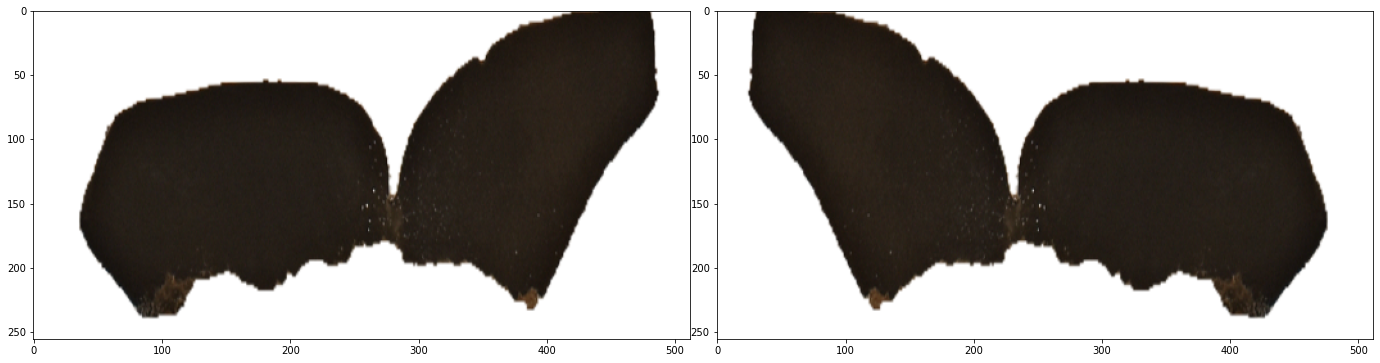

In [19]:
for valid_data in dataloader_test:
    images, names = valid_data
names = np.repeat(names, 2)
images = images.numpy()
fig, axs = plt.subplots(1,2,figsize=(19,12))
for i, ax in enumerate(axs.flatten()):
    img = images[i]
    img = np.moveaxis(img,0,2)
    ax.imshow(img)
fig.tight_layout(pad=.1)

#### Use Pytorch Whale model embeddings

In [20]:
checkPoint_start = 20600
fold = 2
model_name = 'seresnext101'
resultDir = './WC_result/{}_{}'.format(model_name, fold)
checkPoint = os.path.join(resultDir, 'checkpoint')

In [21]:
model = model_whale(num_classes=2233 * 2, inchannels=4, model_name=model_name)

model.load_pretrain(os.path.join(checkPoint, '%08d_model.pth' % (checkPoint_start)), skip=[])

if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
        
ckp = torch.load(os.path.join(checkPoint, '%08d_optimizer.pth' % (checkPoint_start)), map_location=map_location)

In [22]:
%%time

allnames = []
global_feats = []

labelstrs = []
allnames = []
with torch.no_grad():
    model.eval()
    for data in tqdm(dataloader_test):
        images, names = data
        if torch.cuda.is_available():
            images = images.cuda()
        global_feat, _, _ = model(images)
        global_feats.append(global_feat)
        for name in names:
            allnames.append(name)
    all_global_feat = normalize(torch.cat(global_feats), axis=-1) 
    if torch.cuda.is_available():
        all_global_feat_np = all_global_feat.cpu().numpy()
    else:
        all_global_feat_np = all_global_feat.numpy()
    

100%|██████████| 1/1 [00:34<00:00, 34.60s/it]

CPU times: user 34.6 s, sys: 72.2 ms, total: 34.6 s
Wall time: 34.6 s


In [23]:
names

['sperm_whale_example.jpg']

In [24]:
vectors = all_global_feat_np[::2, :]

In [25]:
from postprocessing.euclidean_distance import L2

In [26]:
dist = L2(model_name, fold, checkPoint_start)

In [27]:
dist.index.labels

array(['PM-WWA-20180811-093.jpg', 'PM-WWA-20120430-011.jpg',
       'PM-WWA-20110724-023.jpg', ..., 'PM-WWA-20090811-050.jpg',
       'PM-WWA-20060627-020.jpg', 'PM-WWA-20060715-071.jpg'], dtype=object)

In [28]:
dist.index.add_img(vectors, allnames)

In [29]:
dist, imgs = dist.index.query(np.expand_dims(vectors, 1).reshape(1, -1), 20+1)

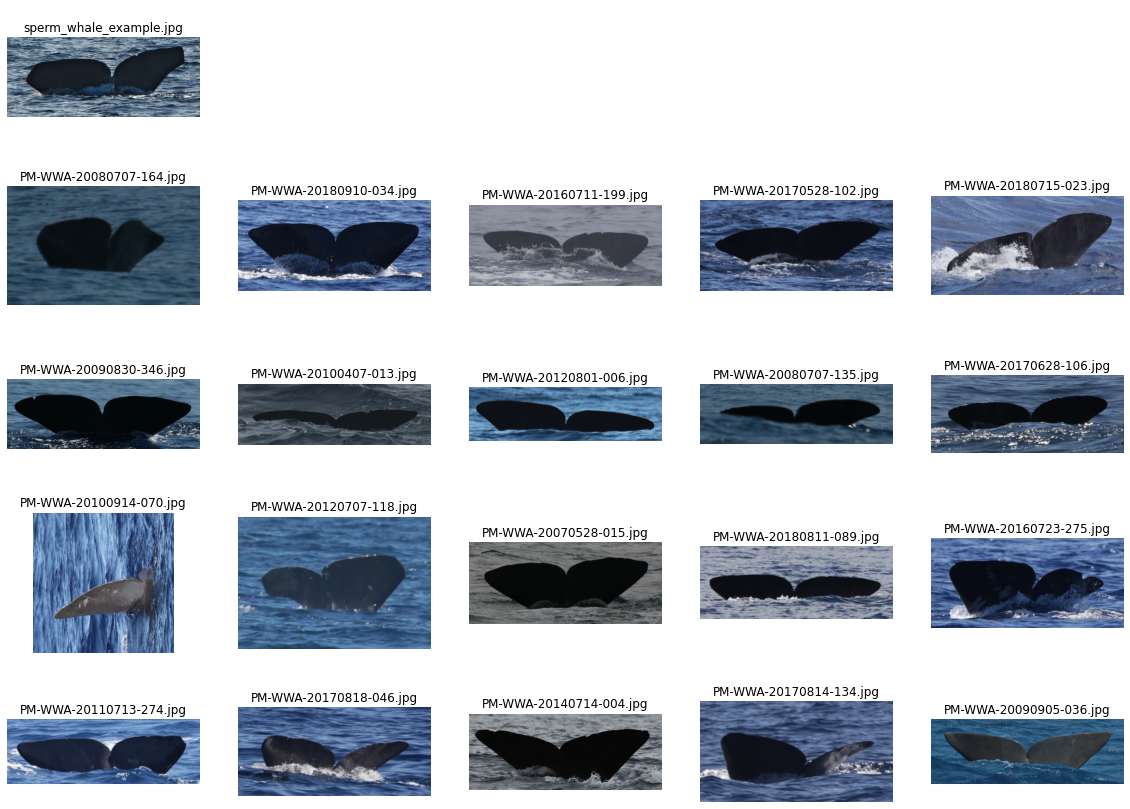

In [30]:
fp = './WC_input/'

f, axarr = plt.subplots(5, 5)
f.set_figwidth(20)
f.set_figheight(15)

for i in range(0, 20):
    img_name = imgs[i+1]
    img =  plt.imread(fp +'data/'+img_name)

    axarr[int(i/5)+1, i%5].imshow(img)
    axarr[int(i/5)+1, i%5].axis('off')
    axarr[int(i/5)+1, i%5].set_title(img_name)

img = plt.imread(fp + 'prediction/'+imgs[0])
axarr[0, 0].imshow(img)
axarr[0, 0].axis('off')
axarr[0, 0].set_title(imgs[0])
axarr[0, 1].axis('off')
axarr[0, 2].axis('off')
axarr[0, 3].axis('off')
axarr[0, 4].axis('off')

plt.show()

# ... 
